# Second order updates on the $\alpha_{\epsilon}(A)$ level set
This script serves to measure the effectiveness of different retractions on the smoothed spectral abscissa level set

In [27]:
import numpy as np
from scipy.linalg import solve_continuous_lyapunov
import matplotlib.pyplot as plt
from tqdm import tqdm
from ssa import ssa, optimize_ssa, ssa_newton_retraction

In [28]:
N = 32
n_matrices = 100
eps = 0.03
target = -0.1

In [29]:
# generate a lot of stability optimized matrices
As = [optimize_ssa(np.random.normal(0.0, 1.0, size=(N, N)), eps, target, step_size=1.0, iters=40)[0] for i in tqdm(range(n_matrices))]
# As = [A for A in As if ssa(A, eps, grad=False)[0] < 0.5 * target]
# len(As)

100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


In [30]:
max([ssa(A, eps, grad=False)[0] for A in As])

-0.07385374723152333

In [31]:
def lyap_differential(X: np.array, Y: np.array, V: np.array):
    Q = V @ Y + Y @ V.T
    return solve_continuous_lyapunov(X, -Q)

def random_tangent(g: np.array):

    # flatten and remember original shape
    orig_shape = g.shape    
    g = np.ravel(g)

    # generate random ambient vector
    v = np.random.random(size=(g.size,))

    # remove the component in the direction of g
    g_comp = np.dot(v, g) / np.dot(g, g)
    v = v - (g_comp * g)

    # rescale
    v = v / np.linalg.norm(v)

    # reshape
    v = np.reshape(v, orig_shape)

    return v

def hvp(A: np.array, V: np.array, s: float, Q: np.array, P: np.array):

    n = A.shape[0]

    # NOTE: Maybe we drop the s part here...
    # DVP = lyap_differential(A - s * np.identity(n), P, V)
    # DVQ = lyap_differential(A.T - s * np.identity(n), Q, V)
    DVP = lyap_differential(A, P, V)
    DVQ = lyap_differential(A.T, Q, V.T) # NOTE: This is the most shaky part...

    # if np.linalg.norm(np.ravel(DVP - DVQ.T)) < 0.1:
    #     print("interestingment")

    DVQP = DVQ @ P + Q @ DVP

    QP = Q@P
    TrQP = np.trace(QP)
    TrDVQP = np.trace(DVQP)

    DV_ssa = ((DVQP * TrQP) - (QP * TrDVQP)) / (TrQP**2)

    return DV_ssa

def compute_corrections(A: np.array, V: np.array, s: float, G: np.array, Q: np.array, P: np.array):

    # compute Hessian-Vector products
    H_1 = hvp(A, G, s, Q, P)
    H_2 = hvp(A, V, s, Q, P)

    h_1 = np.ravel(H_1)
    h_2 = np.ravel(H_2)
    g = np.ravel(G)
    v = np.ravel(V)

    # compute coefficients of the quadratic
    a = np.dot(g, h_1)
    b = 2 * (np.dot(g, g) + np.dot(g, h_1))
    c = np.dot(v, h_2)

    alpha_1 = -c / (2 * np.dot(g, g)) # no need for h_1
    # NOTE: should maybe be using the stable version of the quadratic formula
    # alpha_2_1 = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a) # quadratic solution +
    # alpha_2_2 = (-b - np.sqrt(b**2 - 4 * a * c)) / (2 * a) # quadratic solutoin -

    alpha_2_1 = (2 * c) / (-b - np.sqrt(b**2 - 4 * a * c))
    # alpha_2_2 = (2 * c) / (-b + np.sqrt(b**2 - 4 * a * c))
    alpha_2_2 = -c / b


    return alpha_1, alpha_2_1, alpha_2_2

In [48]:
# test the HVP alignment
thetas = []

# for each matrix A
for A in As:    
    for i in range(5):
        ## find the current ssa and gradient
        s, G, Q, P = ssa(A, eps, ret_QP=True)

        ## pick a direction tangent to the surface
        V = random_tangent(G) * 1.0

        ## step
        A_1 = A + (0.5 * V)
        A_2 = A - (0.5 * V)

        ## calculate new differential = 2 PQ / Tr(PQ)
        s_1, G_1, Q_1, P_1 = ssa(A_1, eps, ret_QP=True)
        s_2, G_2, Q_2, P_2 = ssa(A_2, eps, ret_QP=True)

        ## calculate HVP at original in the direction V
        H = hvp(A, V, s, Q, P)

        ## See if the difference between the differentials aligns with V
        D = G_1 - G_2

        vec_D = np.ravel(D)
        vec_H = np.ravel(H)

        theta = np.arccos(np.dot(vec_D, vec_H) / (np.linalg.norm(vec_D) * np.linalg.norm(vec_H)))

        theta = theta * 180 / np.pi

        thetas.append(theta)

(array([ 6.,  3.,  4., 16., 19., 41., 49., 70., 63., 48., 46., 31., 25.,
        22., 19.,  6.,  6.,  6.,  2.,  6.,  1.,  5.,  4.,  1.,  1.]),
 array([2.5029891 , 2.62200444, 2.74101977, 2.86003511, 2.97905045,
        3.09806579, 3.21708113, 3.33609647, 3.45511181, 3.57412715,
        3.69314248, 3.81215782, 3.93117316, 4.0501885 , 4.16920384,
        4.28821918, 4.40723452, 4.52624986, 4.64526519, 4.76428053,
        4.88329587, 5.00231121, 5.12132655, 5.24034189, 5.35935723,
        5.47837257]),
 <BarContainer object of 25 artists>)

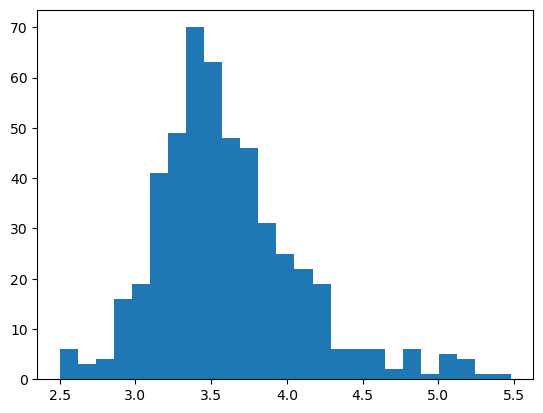

In [49]:
# NOTE: This needs to be fixed otherwise we can't really be confident
plt.hist(thetas, bins=25)

In [34]:
ssas = [ssa(A, eps, grad=False) for A in As]
sas = [np.max(np.real(np.linalg.eigvals(A))) for A in As]

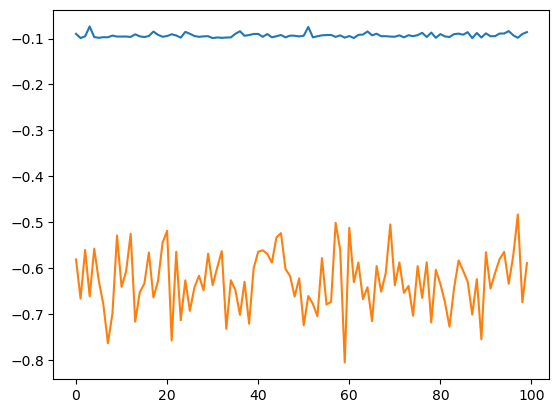

In [35]:
plt.plot(ssas)
plt.plot(sas)

(array([4., 4., 5., 6., 5., 5., 5., 6., 8., 3., 4., 4., 5., 5., 2., 1., 2.,
        5., 5., 3., 1., 0., 2., 1., 0., 2., 1., 0., 2., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
 array([-0.09921268, -0.0987055 , -0.09819833, -0.09769115, -0.09718397,
        -0.09667679, -0.09616961, -0.09566243, -0.09515525, -0.09464807,
        -0.0941409 , -0.09363372, -0.09312654, -0.09261936, -0.09211218,
        -0.091605  , -0.09109782, -0.09059064, -0.09008347, -0.08957629,
        -0.08906911, -0.08856193, -0.08805475, -0.08754757, -0.08704039,
        -0.08653322, -0.08602604, -0.08551886, -0.08501168, -0.0845045 ,
        -0.08399732, -0.08349014, -0.08298296, -0.08247579, -0.08196861,
        -0.08146143, -0.08095425, -0.08044707, -0.07993989, -0.07943271,
        -0.07892553, -0.07841836, -0.07791118, -0.077404  , -0.07689682,
        -0.07638964, -0.07588246, -0.07537528, -0.0748681 , -0.07436093,
        -0.07385375]),
 <BarContainer object

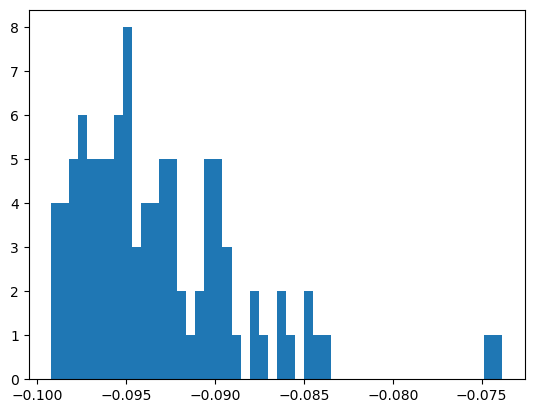

In [36]:
# check that their spectral abscissa are below 0
plt.hist(np.array(ssas), bins=50)

In [83]:
step_size = 0.25

In [84]:
s_dels = [] # step
sp_dels = [] # step, project
sfc_dels = [] # step, FO correct
sfcp_dels = [] # step, FO correct, project
ssc_1_dels = [] # step, SO correct
ssc_1p_dels = [] # step, SO correct, project
ssc_2_dels = [] # step, SO correct
ssc_2p_dels = [] # step, SO correct, project

fo_cs = []
so_c_1s = []
so_c_2s = []

# for each array
for A in As:    

    ## find the current ssa and gradient
    s, G, Q, P = ssa(A, eps, ret_QP=True)
    
    ## pick a direction tangent to the surface
    V = random_tangent(G) * step_size

    ## step
    A_s = A + V

    ## step, project
    A_sp = ssa_newton_retraction(A, V, eps, target)

    fo_c, so_c_1, so_c_2 = compute_corrections(A, V, s, G, Q, P)
    fo_cs.append(fo_c)
    so_c_1s.append(so_c_1)
    so_c_2s.append(so_c_2)

    ## step, FO correct
    A_sfc = A_s + (fo_c * G)
    ## step, FO correct, project
    A_sfcp = ssa_newton_retraction(A, V + (fo_c * G), eps, target)
    
    ## step, SO correct
    A_ssc_1 = A_s + (so_c_1 * G)
    A_ssc_2 = A_s + (so_c_2 * G)
    ## step, SO correct, project
    A_ssc_1p = ssa_newton_retraction(A, V + (so_c_1 * G), eps, target)
    A_ssc_2p = ssa_newton_retraction(A, V + (so_c_2 * G), eps, target)
    
    # find difference from the original s:
    s_dels.append(ssa(A_s, eps, grad=False, ret_QP=False) - s)
    sp_dels.append(ssa(A_sp, eps, grad=False, ret_QP=False) - s)
    sfc_dels.append(ssa(A_sfc, eps, grad=False, ret_QP=False) - s)
    sfcp_dels.append(ssa(A_sfcp, eps, grad=False, ret_QP=False) - s)
    ssc_1_dels.append(ssa(A_ssc_1, eps, grad=False, ret_QP=False) - s)
    ssc_1p_dels.append(ssa(A_ssc_1p, eps, grad=False, ret_QP=False) - s)
    ssc_2_dels.append(ssa(A_ssc_2, eps, grad=False, ret_QP=False) - s)
    ssc_2p_dels.append(ssa(A_ssc_2p, eps, grad=False, ret_QP=False) - s)


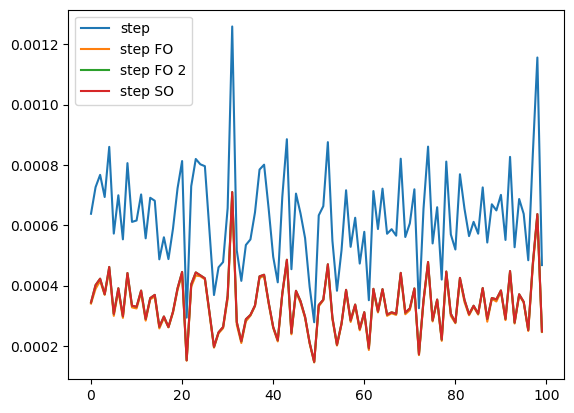

In [85]:
plt.plot(np.abs(s_dels), label="step")
# plt.plot(np.abs(sp_dels))
plt.plot(np.abs(sfc_dels), label="step FO")
# plt.plot(np.abs(sfcp_dels))
plt.plot(np.abs(ssc_2_dels), label="step FO 2")
# plt.plot(np.abs(sfcp_dels))
plt.plot(np.abs(ssc_1_dels), label="step SO")
# plt.plot(np.abs(ssc_1p_dels))
plt.legend()
plt.show()

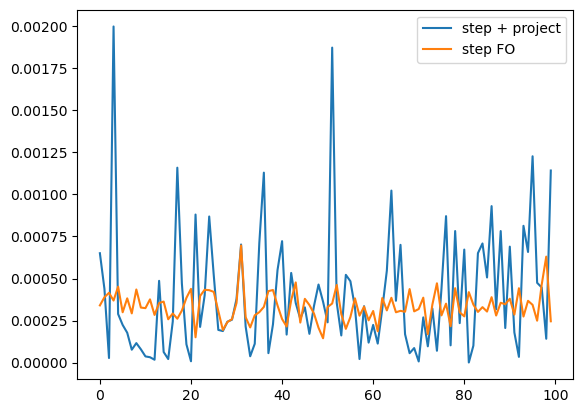

In [86]:
plt.plot(np.abs(sp_dels), label="step + project")
# plt.plot(np.abs(sfcp_dels), label="step FO + project")
plt.plot(np.abs(sfc_dels), label="step FO")
# plt.plot(np.abs(ssc_1p_dels), label="step SO + project")
plt.legend()
# plt.ylim(-0.1, 5.0)
plt.show()

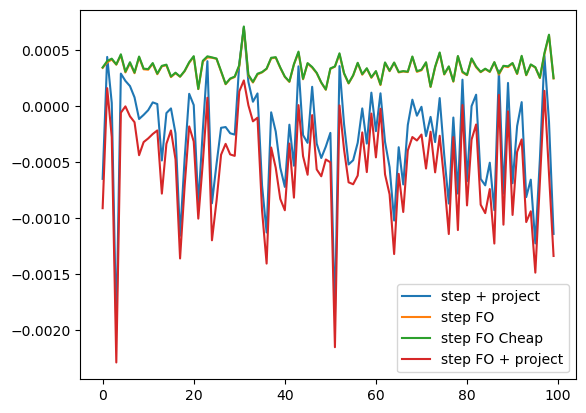

In [87]:
# plt.plot(s_dels, label="step")
plt.plot(sp_dels, label="step + project")
# plt.plot(np.abs(sfcp_dels), label="step FO + project")
plt.plot(sfc_dels, label="step FO")
plt.plot(ssc_2_dels, label="step FO Cheap")
# plt.plot(ssc_1_dels, label="step SO")
plt.plot(sfcp_dels, label="step FO + project")
# plt.plot(ssc_1p_dels, label="step SO + project")
plt.legend()
# plt.yscale("log")
# plt.ylim(-0.1, 5.0)
plt.show()

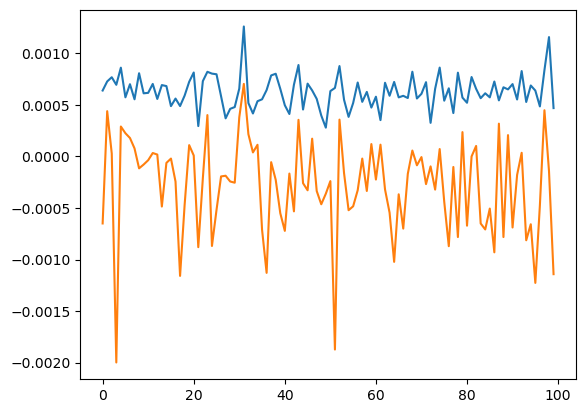

In [88]:
plt.plot(s_dels)
plt.plot(sp_dels)
plt.show()

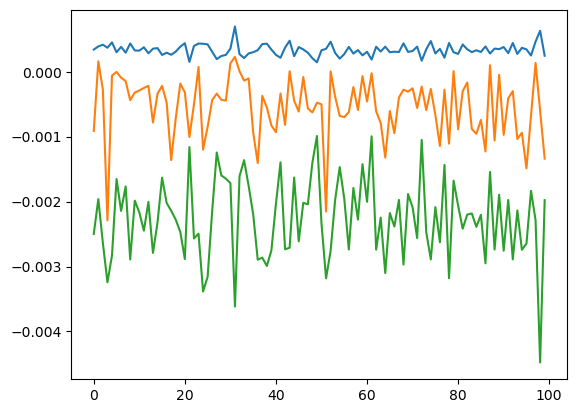

In [89]:
plt.plot(sfc_dels)
plt.plot(sfcp_dels)
plt.plot(fo_cs)
plt.show()

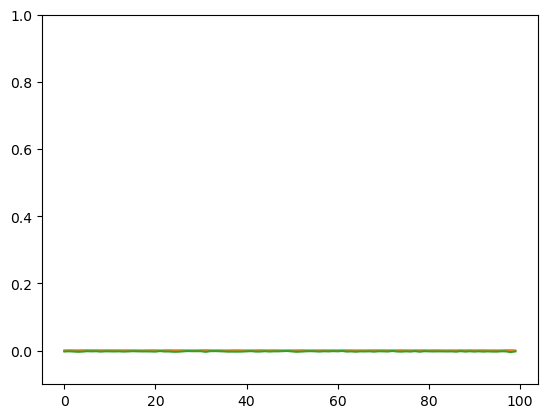

In [90]:
plt.plot(ssc_1_dels)
plt.plot(ssc_1p_dels)
plt.plot(so_c_1s)
plt.ylim(-0.1, 1.0)
plt.show()

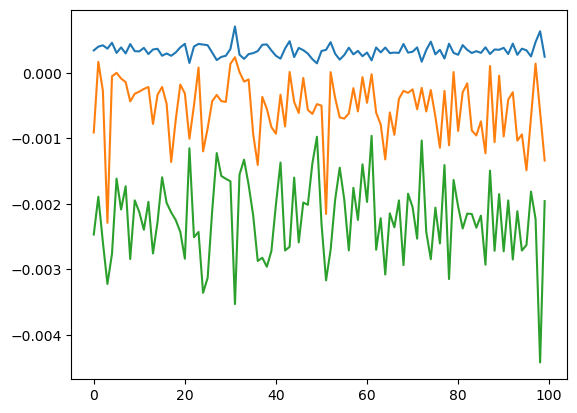

In [91]:
plt.plot(ssc_2_dels)
plt.plot(ssc_2p_dels)
plt.plot(so_c_2s)
plt.show()